# Ablation Study

In [ ]:
"""
DEC training for In-Possession phase + feature-group ablation study.

Adds:
- Five semantic feature groups (G1-G5)
- Single-group removal ablations (train DEC from scratch per ablation)
- Metrics: NMI / ARI vs. full model, cluster centroid drift, team-level stability
"""

import json
import random
from itertools import permutations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score




from scipy.spatial.distance import cdist

def compute_indices(X: np.ndarray, labels: np.ndarray):
    """Compute internal indices used to build AC1/AC2: Iwcss, Isep, Idistcc, Idens."""
    labels = np.asarray(labels)
    uniq = np.unique(labels)
    n_clusters = len(uniq)

    centers = []
    for c in uniq:
        pts = X[labels == c]
        if len(pts) == 0:
            centers.append(np.zeros(X.shape[1], dtype=float))
        else:
            centers.append(pts.mean(axis=0))
    centers = np.asarray(centers)

    # Iwcss: within-cluster sum of squared distances to the corresponding center
    Iwcss = 0.0
    for i, c in enumerate(uniq):
        pts = X[labels == c]
        if len(pts) == 0:
            continue
        Iwcss += float(np.sum((pts - centers[i]) ** 2))

    # Isep: mean pairwise distance between centers (includes diagonal, consistent with your reference)
    Isep = float(np.mean(cdist(centers, centers))) if n_clusters > 0 else 0.0

    # Idistcc and Idens: mean distance-to-center and its std, averaged over valid clusters
    valid_dists, valid_dens = [], []
    for i, c in enumerate(uniq):
        pts = X[labels == c]
        if len(pts) < 2:
            continue
        d = np.linalg.norm(pts - centers[i], axis=1)
        valid_dists.append(float(np.mean(d)))
        valid_dens.append(float(np.std(d)))

    Idistcc = float(np.mean(valid_dists)) if valid_dists else 0.0
    Idens   = float(np.mean(valid_dens)) if valid_dens else 0.0
    return Iwcss, Isep, Idistcc, Idens

def minmax_normalize(val: float, min_val: float, max_val: float, larger_is_better: bool) -> float:
    """Min-max normalize to [0,1]; invert if larger_is_better=False."""
    if np.isclose(max_val - min_val, 0):
        return 1.0
    score = (val - min_val) / (max_val - min_val)
    return float(score) if larger_is_better else float(1 - score)
# ----------------------------
# Data
# ----------------------------
final_df = pd.read_csv("../../create_datasets/final_final_possesion_df.csv")
final_df.set_index("uniqueTeamId", inplace=True)
final_df.fillna(0, inplace=True)

# Keep feature list (column order matters for ablation)
ALL_FEATURES = list(final_df.columns)


# ----------------------------
# DEC model
# ----------------------------
class Encoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int = 10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
        )

    def forward(self, x):
        return self.model(x)


class Decoder(nn.Module):
    def __init__(self, latent_dim: int, output_dim: int):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    def forward(self, z):
        return self.model(z)


class AutoEncoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int = 10):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


class DEC(nn.Module):
    def __init__(self, encoder: nn.Module, cluster_centers: torch.Tensor):
        super().__init__()
        self.encoder = encoder
        self.clusters = nn.Parameter(cluster_centers)

    def forward(self, x):
        z = self.encoder(x)
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.clusters) ** 2, dim=2))
        q = q / torch.sum(q, dim=1, keepdim=True)
        return q


def target_distribution(q: torch.Tensor) -> torch.Tensor:
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()


# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ----------------------------
# Training utilities
# ----------------------------
def train_dec_from_scratch(
    X: np.ndarray,
    k: int = 4,
    latent_dim: int = 10,
    pretrain_epochs: int = 3000,
    dec_epochs: int = 3000,
    lr: float = 1e-3,
    seed: int = 42,
):
    """Train AE -> init KMeans in latent -> DEC refinement. Returns labels + latent centers + latent embeddings."""
    set_seed(seed)

    X_tensor = torch.tensor(X, dtype=torch.float32)

    input_dim = X.shape[1]
    ae = AutoEncoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ae.parameters(), lr=lr)

    # AE pretrain
    print("AE pretrain starts...")
    for i in range(pretrain_epochs):
        optimizer.zero_grad()
        output = ae(X_tensor)
        loss = criterion(output, X_tensor)
        loss.backward()
        optimizer.step()
        if i%500 == 0:
            print(f"Epoch: {i}")

    # Init clusters with KMeans on latent z
    z = ae.encoder(X_tensor).detach().cpu().numpy()
    kmeans = KMeans(n_clusters=k, random_state=seed).fit(z)
    init_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)

    dec = DEC(ae.encoder, init_centers.clone())
    dec_optimizer = optim.Adam(dec.parameters(), lr=lr)

    # DEC refinement
    print("DEC refinement starts...")
    for i in range(dec_epochs):
        q = dec(X_tensor)
        p = target_distribution(q.detach())
        kl = torch.nn.functional.kl_div(q.log(), p, reduction="batchmean")
        dec_optimizer.zero_grad()
        kl.backward()
        dec_optimizer.step()
        if i%500 == 0:
            print(f"Epoch: {i}")

    with torch.no_grad():
        z_final = dec.encoder(X_tensor).detach().cpu().numpy()
        q_final = dec(X_tensor).detach().cpu().numpy()
        labels = np.argmax(q_final, axis=1)
        centers = dec.clusters.detach().cpu().numpy()

    return labels, centers, z_final


def align_centers_by_min_sum_distance(cent_full: np.ndarray, cent_alt: np.ndarray):
    """Align alt centers to full centers via brute-force permutation (OK for small k like 4)."""
    k = cent_full.shape[0]
    best_perm = None
    best_cost = 1e18
    for perm in permutations(range(k)):
        cost = float(np.sum(np.linalg.norm(cent_full - cent_alt[list(perm)], axis=1)))
        if cost < best_cost:
            best_cost = cost
            best_perm = perm
    return np.array(best_perm), best_cost / k  # average per-cluster drift


def majority_label_per_team(index_unique_team_id: pd.Index, labels: np.ndarray) -> pd.Series:
    """Team-level label via majority voting over matches. Expects index 'teamId---matchId'."""
    tmp = pd.DataFrame({
        "uniqueTeamId": index_unique_team_id.astype(str).values,
        "label": labels
    })
    tmp["teamId"] = tmp["uniqueTeamId"].str.split("---").str[0].astype(int)

    # Mode (majority). If tie, pandas mode returns multiple; take first for determinism.
    maj = tmp.groupby("teamId")["label"].agg(lambda x: x.mode().iloc[0])
    return maj


In [11]:
# ----------------------------
# Feature-group definitions (G1-G5)
# ----------------------------
FEATURE_GROUPS = {
    # G1 — Passing Volume & Network Structure
    "G1_PassingVolume_Network": [
        "Total_Passes",
        "Connectivity",
    ],
    # G2 — Passing Motifs & Combinational Patterns
    "G2_PassingMotifs": [
        "ABAB", "ABCA", "ABCB", "ABCD",
    ],
    # G3 — Passing Directionality (Global & Spatial)
    "G3_PassingDirectionality_GlobalSpatial": [
        "Backward Pass Ratio", "Forward Pass Ratio", "Side Pass Ratio",
        "Backward Pass_Zone_1 Ratio", "Backward Pass_Zone_2 Ratio", "Backward Pass_Zone_3 Ratio",
        "Forward Pass_Zone_1 Ratio", "Forward Pass_Zone_2 Ratio", "Forward Pass_Zone_3 Ratio",
        "Side Pass_Zone_1 Ratio", "Side Pass_Zone_2 Ratio", "Side Pass_Zone_3 Ratio",
    ],
    # G4 — Spatial Passing Distribution & Risk Profile
    "G4_SpatialPassRiskProfile": [
        "High_pass_Ratio_Total", "Low_pass_Ratio_Total",
        "High_pass_Ratio_Zone1", "Low_pass_Ratio_Zone1",
        "High_pass_Ratio_Zone2", "Low_pass_Ratio_Zone2",
        "High_pass_Ratio_Zone3", "Low_pass_Ratio_Zone3",
    ],
    # G5 — Shooting Volume & Shot Selection
    "G5_Shooting": [
        "Total Shots",
        "Far Shots Ratio",
        "Middle Distance Shots Ratio",
        "Near Shots Ratio",
    ],
}

# Sanity check: keep only groups that exist in the dataset (guards against typos / renamed columns)
for g, cols in list(FEATURE_GROUPS.items()):
    FEATURE_GROUPS[g] = [c for c in cols if c in ALL_FEATURES]

l = 0
for i in FEATURE_GROUPS:
    l += len(FEATURE_GROUPS[i])
l == len(ALL_FEATURES)

True

In [3]:
# ----------------------------
# Run: Full model + single-group removal ablations
# ----------------------------
k = 4
latent_dim = 10
seed = 42

# Scale (fit per experiment to avoid leakage across feature sets)
def fit_transform_scaled(df: pd.DataFrame) -> np.ndarray:
    scaler = StandardScaler()
    return scaler.fit_transform(df.values)

# Full model
X_full = fit_transform_scaled(final_df)
labels_full, centers_full, z_full = train_dec_from_scratch(
    X_full, k=k, latent_dim=latent_dim, seed=seed
)

sil_full = silhouette_score(z_full, labels_full)
team_full = majority_label_per_team(final_df.index, labels_full)

results = []
Iwcss_full, Isep_full, Idistcc_full, Idens_full = compute_indices(z_full, labels_full)
results.append({
    "Setting": "Full",
    "Removed_Group": "None",
    "NMI_vs_Full": 1.0,
    "ARI_vs_Full": 1.0,
    "CentroidDrift_vs_Full": 0.0,
    "TeamStability_vs_Full": 1.0,
    "Silhouette": sil_full,
    "Iwcss": Iwcss_full,
    "Isep": Isep_full,
    "Idistcc": Idistcc_full,
    "Idens": Idens_full,
    "Num_Features": final_df.shape[1],
})

AE pretrain starts...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
DEC refinement starts...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500


In [14]:
# Ablations: remove one group at a time, retrain from scratch
for group_name, group_cols in FEATURE_GROUPS.items():
    cols_keep = [c for c in ALL_FEATURES if c not in set(group_cols)]
    df_abl = final_df[cols_keep].copy()

    X_abl = fit_transform_scaled(df_abl)
    labels_abl, centers_abl, z_abl = train_dec_from_scratch(
        X_abl, k=k, latent_dim=latent_dim, seed=seed
    )

    # Cluster consistency vs full (labels are permutation-sensitive; NMI/ARI handle label permutation)
    nmi = normalized_mutual_info_score(labels_full, labels_abl)
    ari = adjusted_rand_score(labels_full, labels_abl)

    # Centroid drift vs full (align centers to address permutation)
    _, drift = align_centers_by_min_sum_distance(centers_full, centers_abl)

    # Team-level stability (majority label agreement across teams)
    team_abl = majority_label_per_team(df_abl.index, labels_abl)
    common_teams = team_full.index.intersection(team_abl.index)
    team_stability = float((team_full.loc[common_teams] == team_abl.loc[common_teams]).mean())

    sil = silhouette_score(z_abl, labels_abl)
    
    Iwcss, Isep, Idistcc, Idens = compute_indices(z_abl, labels_abl)
    results.append({
        "Setting": f"Ablation_{group_name}",
        "Removed_Group": group_name,
        "NMI_vs_Full": float(nmi),
        "ARI_vs_Full": float(ari),
        "CentroidDrift_vs_Full": float(drift),
        "TeamStability_vs_Full": float(team_stability),
        "Silhouette": float(sil),
        "Iwcss": float(Iwcss),
        "Isep": float(Isep),
        "Idistcc": float(Idistcc),
        "Idens": float(Idens),
        "Num_Features": df_abl.shape[1],
    })

results_df = pd.DataFrame(results).sort_values(["Setting"])

AE pretrain starts...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
DEC refinement starts...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
AE pretrain starts...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
DEC refinement starts...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
AE pretrain starts...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
DEC refinement starts...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
AE pretrain starts...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
DEC refinement starts...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
AE pretrain starts...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500
DEC refinement starts...
Epoch: 0
Epoch: 500
Epoch: 1000
Epoch: 1500
Epoch: 2000
Epoch: 2500


In [18]:
# ----------------------------
# AC1 / AC2 (cluster validity composites)
# We normalize indices across all settings produced in this run (Full + ablations),
# then compute AC1 and AC2 exactly as in your reference script.
# ----------------------------
index_min = {
    "Iwcss": float(results_df["Iwcss"].min()),
    "Isep": float(results_df["Isep"].min()),
    "Idistcc": float(results_df["Idistcc"].min()),
    "Idens": float(results_df["Idens"].min()),
}
index_max = {
    "Iwcss": float(results_df["Iwcss"].max()),
    "Isep": float(results_df["Isep"].max()),
    "Idistcc": float(results_df["Idistcc"].max()),
    "Idens": float(results_df["Idens"].max()),
}

def _row_ac(row):
    Iwcss_m  = minmax_normalize(row["Iwcss"],   index_min["Iwcss"],   index_max["Iwcss"],   larger_is_better=False)
    Isep_m   = minmax_normalize(row["Isep"],    index_min["Isep"],    index_max["Isep"],    larger_is_better=True)
    Idistcc_m= minmax_normalize(row["Idistcc"], index_min["Idistcc"], index_max["Idistcc"], larger_is_better=False)
    Idens_m  = minmax_normalize(row["Idens"],   index_min["Idens"],   index_max["Idens"],   larger_is_better=False)

    AC1 = (Iwcss_m + Isep_m + Idistcc_m + Idens_m) / 4.0
    AC2 = (1.0 * Iwcss_m + 0.5 * Isep_m + 1.0 * Idistcc_m + 0.25 * Idens_m) / 2.75
    return pd.Series({"AC1": float(AC1), "AC2": float(AC2)})

results_df[["AC1", "AC2"]] = results_df.apply(_row_ac, axis=1)

# Save outputs
results_df.to_csv("dec_feature_group_ablation_results.csv", index=False)
results_df

results_df

,Setting,Removed_Group,NMI_vs_Full,ARI_vs_Full,CentroidDrift_vs_Full,TeamStability_vs_Full,Silhouette,Iwcss,Isep,Idistcc,Idens,Num_Features,AC1,AC2
1,Ablation_G1_PassingVolume_Network,G1_PassingVolume_Network,0.396049,0.351187,18.303022,0.081633,0.933691,1311.123886,10.218477,0.465820,0.354701,28,0.587299,0.623375
2,Ablation_G2_PassingMotifs,G2_PassingMotifs,0.447305,0.409175,15.433604,0.142857,0.943896,1330.170670,11.422797,0.402470,0.343209,26,0.771309,0.796724
3,Ablation_G3_PassingDirectionality_GlobalSpatial,G3_PassingDirectionality_GlobalSpatial,0.435288,0.395411,19.528778,0.285714,0.936710,994.952637,9.339104,0.386638,0.351885,18,0.652201,0.770052
4,Ablation_G4_SpatialPassRiskProfile,G4_SpatialPassRiskProfile,0.248193,0.211306,16.821346,0.183673,0.902810,2323.618103,9.487559,0.628222,0.472594,22,0.013102,0.009528
5,Ablation_G5_Shooting,G5_Shooting,0.491156,0.458935,17.635143,0.224490,0.913113,2160.640411,10.816938,0.606081,0.450967,26,0.211921,0.181396
0,Full,None,1.000000,1.000000,0.000000,1.000000,0.950317,930.776138,12.171866,0.398567,0.288272,30,0.987655,0.982044


# Supervised Training

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
import lightgbm as lgb

In [21]:
# ----------------------------
# Surrogate supervised models for explainability (predict DEC clusters)
# ----------------------------
# We train high-fidelity multiclass classifiers to approximate DEC assignments.
# These models will later be used for feature importance / SHAP-based explanations.

X_sup = final_df.values
y_sup = labels_full

X_tr, X_te, y_tr, y_te = train_test_split(
    X_sup, y_sup, test_size=0.2, random_state=seed, stratify=y_sup
)


In [22]:
# XGBoost (multiclass)
xgb_clf = xgb.XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="multi:softprob",
    num_class=k,
    random_state=seed,
    n_jobs=-1,
    tree_method="hist",
)

xgb_clf.fit(
    X_tr, y_tr,
    eval_set=[(X_te, y_te)],
    verbose=False,
)

xgb_pred = xgb_clf.predict(X_te)
xgb_acc = float(accuracy_score(y_te, xgb_pred))
xgb_f1  = float(f1_score(y_te, xgb_pred, average="macro"))


In [23]:
# LightGBM (multiclass)
lgbm_clf = lgb.LGBMClassifier(
    n_estimators=1200,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multiclass",
    num_class=k,
    random_state=seed,
    n_jobs=-1,
)

lgbm_clf.fit(
    X_tr, y_tr,
    eval_set=[(X_te, y_te)],
    eval_metric="multi_logloss",
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],
)

lgbm_pred = lgbm_clf.predict(X_te)
lgbm_acc = float(accuracy_score(y_te, lgbm_pred))
lgbm_f1  = float(f1_score(y_te, lgbm_pred, average="macro"))

In [28]:
lgbm_pred = lgbm_clf.predict(X_te)
lgbm_acc = float(accuracy_score(y_te, lgbm_pred))
lgbm_f1  = float(f1_score(y_te, lgbm_pred, average="macro"))

# Multinomial Logistic Regression (scaled)
# Useful as a simple, linear surrogate baseline.
logreg_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=5000,
        n_jobs=-1,
        random_state=seed,
    )),
])

logreg_clf.fit(X_tr, y_tr)
logreg_pred = logreg_clf.predict(X_te)
logreg_acc = float(accuracy_score(y_te, logreg_pred))
logreg_f1  = float(f1_score(y_te, logreg_pred, average="macro"))

In [45]:
perf_df = pd.DataFrame([
    {"Model": "XGBoost",  "Accuracy": xgb_acc,  "MacroF1": xgb_f1},
    {"Model": "LightGBM", "Accuracy": lgbm_acc, "MacroF1": lgbm_f1},
    {"Model": "Logistic Regression (Multinomial)", "Accuracy": logreg_acc, "MacroF1": logreg_f1},
]).sort_values(["MacroF1", "Accuracy"], ascending=False)

print("\nSurrogate model performance (test split):")
perf_df.to_csv("surrogate_model_performance.csv", index=False)
perf_df


Surrogate model performance (test split):


,Model,Accuracy,MacroF1
2,Logistic Regression (Multinomial),0.945280,0.944463
0,XGBoost,0.911081,0.910711
1,LightGBM,0.893297,0.893230


# Explainability

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


# ----------------------------
# 1) Train multinomial LogReg surrogate
# ----------------------------
feature_names = list(final_df.columns)

X_sup = final_df.values
y_sup = labels_full.astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_sup, y_sup, test_size=0.2, random_state=seed, stratify=y_sup
)

logreg = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        solver="lbfgs",            # multinomial supported
        multi_class="auto",        # works as multinomial for multiclass
        max_iter=5000,
        random_state=seed
    ))
])

logreg.fit(X_tr, y_tr)

y_pred = logreg.predict(X_te)
acc = float(accuracy_score(y_te, y_pred))
mf1 = float(f1_score(y_te, y_pred, average="macro"))
print(f"LogReg surrogate (test): Accuracy={acc:.4f}, MacroF1={mf1:.4f}")

LogReg surrogate (test): Accuracy=0.9480, MacroF1=0.9474


In [5]:
# ----------------------------
# 2) Extract standardized coefficients
#    (because features are standardized in the pipeline)
# ----------------------------
clf = logreg.named_steps["clf"]
coef = clf.coef_  # shape: (n_classes, n_features)
classes = clf.classes_

coef_df = pd.DataFrame(coef, index=[f"Cluster {c}" for c in classes], columns=feature_names)

# Save raw coefficients
coef_df.to_csv("logreg_coefficients_by_cluster.csv", index=True)

# Global importance: mean absolute coefficient across clusters
global_importance = coef_df.abs().mean(axis=0).sort_values(ascending=False)
global_imp_df = global_importance.rename("MeanAbsCoef").to_frame()
global_imp_df.to_csv("logreg_global_importance.csv", index=True)

print("\nTop 10 global features (mean |coef| across clusters):")
global_importance


Top 10 global features (mean |coef| across clusters):


Total_Passes                   2.197729
Forward Pass Ratio             1.824941
Side Pass Ratio                1.726809
Connectivity                   1.720855
High_pass_Ratio_Zone2          1.271060
Side Pass_Zone_2 Ratio         1.241759
Forward Pass_Zone_1 Ratio      1.229378
Low_pass_Ratio_Zone1           1.164694
Low_pass_Ratio_Zone2           1.143476
High_pass_Ratio_Total          1.119006
Low_pass_Ratio_Zone3           1.061729
High_pass_Ratio_Zone1          1.054532
Backward Pass_Zone_1 Ratio     1.041344
Forward Pass_Zone_2 Ratio      1.035548
High_pass_Ratio_Zone3          1.027995
Low_pass_Ratio_Total           1.014452
Side Pass_Zone_3 Ratio         0.991766
Backward Pass_Zone_3 Ratio     0.814389
Middle Distance Shots Ratio    0.784308
Near Shots Ratio               0.764039
Total Shots                    0.750591
Forward Pass_Zone_3 Ratio      0.715957
ABAB                           0.660924
ABCA                           0.625017
ABCB                           0.529754


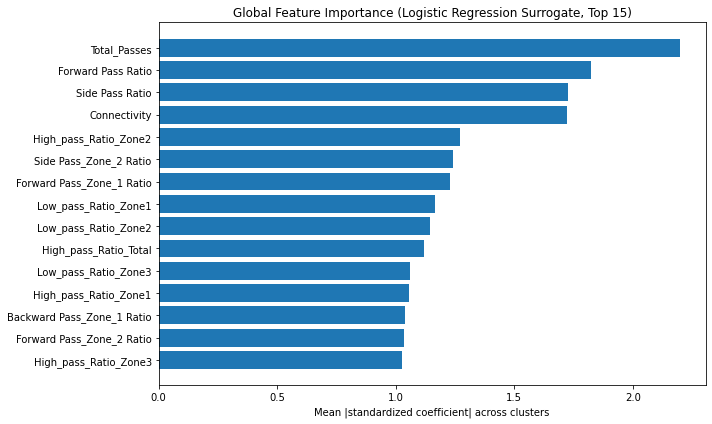

In [6]:
# ----------------------------
# 3) Plot: Global feature importance (Top N)
# ----------------------------
def plot_global_importance(global_importance_series: pd.Series, top_n: int = 15, save_path: str = None):
    s = global_importance_series.head(top_n).iloc[::-1]  # reverse for horizontal bar (largest at top)
    plt.figure(figsize=(10, 6))
    plt.barh(s.index, s.values)
    plt.xlabel("Mean |standardized coefficient| across clusters")
    plt.title(f"Global Feature Importance (Logistic Regression Surrogate, Top {top_n})")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    
    return s

s = plot_global_importance(global_importance, top_n=15, save_path="logreg_global_importance_top15.png")

In [7]:
s.iloc[::-1]

Total_Passes                  2.197729
Forward Pass Ratio            1.824941
Side Pass Ratio               1.726809
Connectivity                  1.720855
High_pass_Ratio_Zone2         1.271060
Side Pass_Zone_2 Ratio        1.241759
Forward Pass_Zone_1 Ratio     1.229378
Low_pass_Ratio_Zone1          1.164694
Low_pass_Ratio_Zone2          1.143476
High_pass_Ratio_Total         1.119006
Low_pass_Ratio_Zone3          1.061729
High_pass_Ratio_Zone1         1.054532
Backward Pass_Zone_1 Ratio    1.041344
Forward Pass_Zone_2 Ratio     1.035548
High_pass_Ratio_Zone3         1.027995
dtype: float64

In [9]:
name_dict = {
    0:"Reactive Direct",
    1:"Highly Proactive",
    2:"Moderately Reactive",
    3:"Balanced Proactive"
}

Reactive Direct Cluster:
negative drivers:
Total_Passes             -1.213621
Low_pass_Ratio_Total     -1.116308
Side Pass Ratio          -1.103741
Low_pass_Ratio_Zone1     -0.961056
Connectivity             -0.869536
Side Pass_Zone_3 Ratio   -0.738946
Side Pass_Zone_2 Ratio   -0.721302
Total Shots              -0.558272
Name: Cluster 0, dtype: float64
positive drivers:
Middle Distance Shots Ratio    0.318216
High_pass_Ratio_Zone3          0.523758
Forward Pass_Zone_2 Ratio      0.657556
Backward Pass_Zone_1 Ratio     0.692084
Forward Pass_Zone_1 Ratio      0.783394
High_pass_Ratio_Total          0.968588
High_pass_Ratio_Zone2          1.101232
Forward Pass Ratio             1.166294
Name: Cluster 0, dtype: float64
Highly Proactive Cluster:
negative drivers:
Forward Pass Ratio            -2.904022
High_pass_Ratio_Zone2         -2.383272
Forward Pass_Zone_2 Ratio     -2.071095
High_pass_Ratio_Total         -1.995173
Backward Pass_Zone_1 Ratio    -1.901976
Forward Pass_Zone_1 Ratio     -

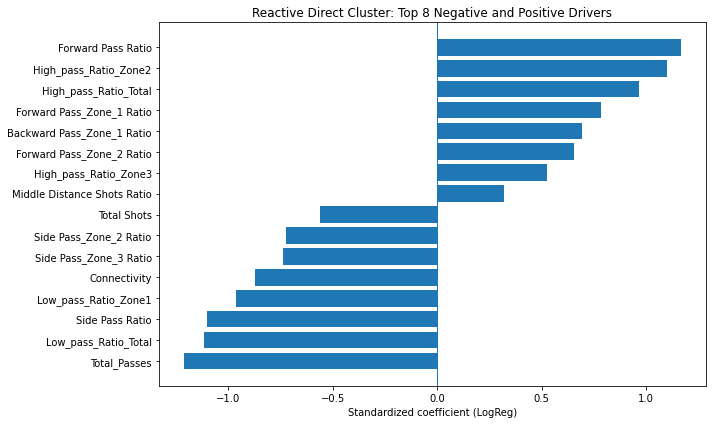

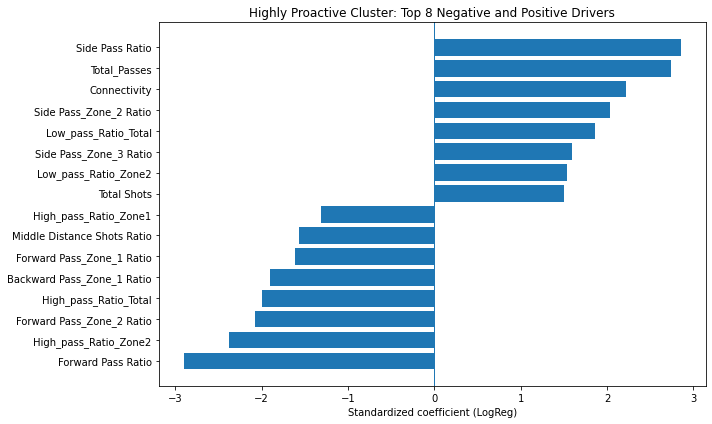

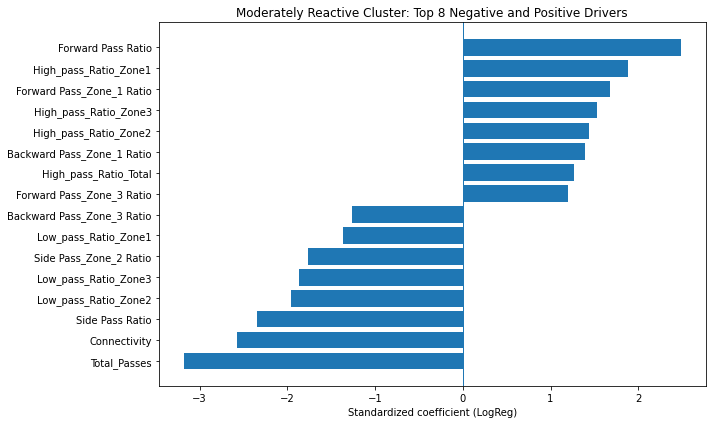

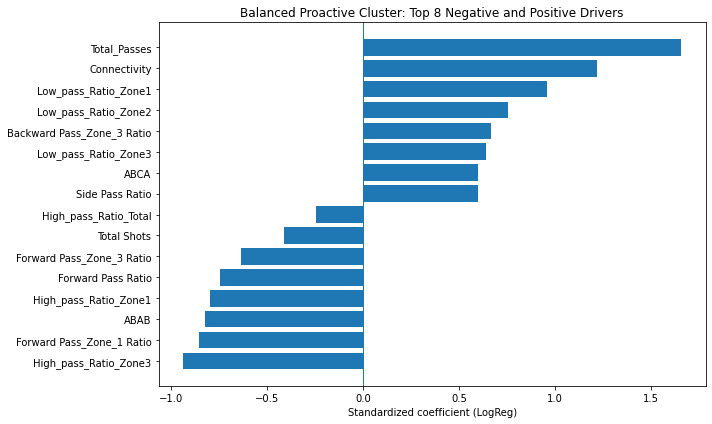

In [12]:
# ----------------------------
# 4) Plot: Per-cluster top positive & negative drivers
# ----------------------------
def plot_cluster_drivers(
    coef_df: pd.DataFrame,
    cluster_id: int,
    top_n: int = 10,
    save_path: str = None
):
    row_name = f"Cluster {cluster_id}"
    if row_name not in coef_df.index:
        raise ValueError(f"{row_name} not found in coef_df.index. Available: {list(coef_df.index)[:5]} ...")

    s = coef_df.loc[row_name].sort_values()

    neg = s.head(top_n)                 # most negative
    pos = s.tail(top_n)                 # most positive
    combined = pd.concat([neg, pos])

    plt.figure(figsize=(10, 6))
    plt.barh(combined.index, combined.values)
    plt.axvline(0, linewidth=1)
    plt.xlabel("Standardized coefficient (LogReg)")
    plt.title(f"{name_dict[cluster_id]} Cluster: Top {top_n} Negative and Positive Drivers")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    #plt.show()
    
    print(f"{name_dict[cluster_id]} Cluster:")
    print("negative drivers:")
    print(neg)
    print("positive drivers:")
    print(pos)

# Example: plot for every cluster
for c in classes:
    plot_cluster_drivers(
        coef_df=coef_df,
        cluster_id=int(c),
        top_n=8,
        save_path=f"logreg_cluster_{int(c)}_drivers.png"
    )


In [41]:
# ----------------------------
# 5) Create a compact table for paper:
#    one feature per column
# ----------------------------
def top_features_table(coef_df: pd.DataFrame, top_n: int = 5) -> pd.DataFrame:
    rows = []
    for idx in coef_df.index:
        s = coef_df.loc[idx].sort_values()

        neg_feats = list(s.head(top_n).index)
        pos_feats = list(s.tail(top_n).index)

        row = {"Cluster": idx}
        for i in range(top_n):
            row[f"Neg_{i+1}"] = neg_feats[i]
            row[f"Pos_{i+1}"] = pos_feats[::-1][i]  # reverse so strongest positive is Pos_1

        rows.append(row)

    return pd.DataFrame(rows)


top_feat_df = top_features_table(coef_df, top_n=6)
top_feat_df.to_csv("logreg_top_features_per_cluster.csv", index=False)

print("\nTop features per cluster (saved to logreg_top_features_per_cluster.csv)")
top_feat_df



Top features per cluster (saved to logreg_top_features_per_cluster.csv)


,Cluster,Neg_1,Pos_1,Neg_2,Pos_2,Neg_3,Pos_3,Neg_4,Pos_4,Neg_5,Pos_5,Neg_6,Pos_6
0,Cluster 0,Total_Passes,Forward Pass Ratio,Low_pass_Ratio_Total,High_pass_Ratio_Total,Side Pass Ratio,High_pass_Ratio_Zone2,Low_pass_Ratio_Zone1,Forward Pass_Zone_1 Ratio,Connectivity,Forward Pass_Zone_2 Ratio,Side Pass_Zone_3 Ratio,Backward Pass_Zone_1 Ratio
1,Cluster 1,Forward Pass Ratio,Side Pass Ratio,High_pass_Ratio_Zone2,Total_Passes,Forward Pass_Zone_2 Ratio,Connectivity,High_pass_Ratio_Total,Side Pass_Zone_2 Ratio,Backward Pass_Zone_1 Ratio,Low_pass_Ratio_Total,Forward Pass_Zone_1 Ratio,Low_pass_Ratio_Zone2
2,Cluster 2,Total_Passes,Forward Pass Ratio,Connectivity,High_pass_Ratio_Zone1,Side Pass Ratio,Forward Pass_Zone_1 Ratio,Low_pass_Ratio_Zone2,High_pass_Ratio_Zone3,Low_pass_Ratio_Zone3,High_pass_Ratio_Zone2,Side Pass_Zone_2 Ratio,Backward Pass_Zone_1 Ratio
3,Cluster 3,High_pass_Ratio_Zone3,Total_Passes,Forward Pass_Zone_1 Ratio,Connectivity,High_pass_Ratio_Zone1,Low_pass_Ratio_Zone1,ABAB,Low_pass_Ratio_Zone2,Forward Pass Ratio,Low_pass_Ratio_Zone3,Forward Pass_Zone_3 Ratio,Backward Pass_Zone_3 Ratio
